(400, 600, 3)


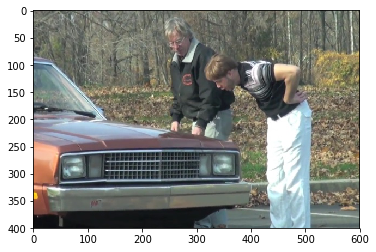

In [9]:
import sys
sys.path.insert(0, "./")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Let's start by importing the image as numpy array

% matplotlib inline

data_dir = "./data/"
img = mpimg.imread(data_dir + "look_at_it.jpg")
imgplot = plt.imshow(img)
print(img.shape)

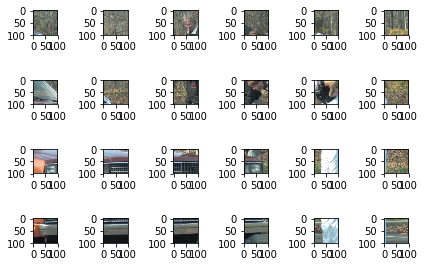

In [2]:
## Let's split the image into chunks
def split_2d_image(img, y_splits, x_splits):
    row_imgs = np.vsplit(img, y_splits)
    img_list = []
    for row in row_imgs:
        img_list.append(np.hsplit(row, x_splits))
    return img_list

img_list = split_2d_image(img, 4, 6)
fig=plt.figure(figsize=(len(img_list[0]), len(img_list)))
rows = len(img_list)
columns = len(img_list[0])
count = 1

for row in range(rows):
    for col in range(columns):
        fig.add_subplot(rows, columns, count)
        plt.imshow(img_list[row][col],interpolation='nearest')
        count += 1

fig.tight_layout()
plt.show()

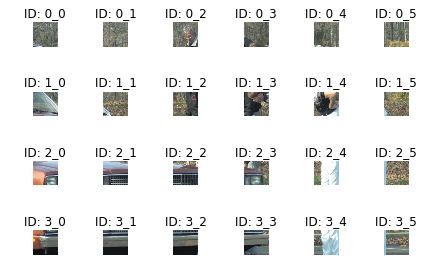

In [3]:
## Now we need to attach relevant ID's to each image. 
## This is so when we map the image pieces back together, they will know where to go.
## There are multiple ways of doing this... TODO: think of best way

## Most obvious: Two digit ID's: XY where first digit corresponds to row and second digit corresponds to column



def label(img_list):
    try:
        image_map = {}
        for row in range(len(img_list)):
            for col in range(len(img_list[0])):
                image_map[str(row) + '_' + str(col)] = img_list[row][col]
        return image_map
    except: ##empty list
        raise

image_map = label(img_list)
fig=plt.figure(figsize=(len(img_list[0]), len(img_list)))
count = 1
for key, value in image_map.items():
    fig.add_subplot(rows, columns, count).title.set_text("ID: " + key)
    plt.imshow(value,interpolation='nearest')
    plt.axis('off')
    count += 1

fig.tight_layout()
plt.show()

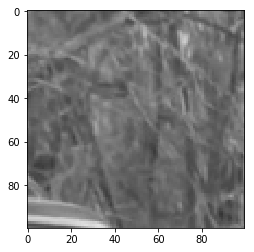

In [4]:
## Now we set a function that will be applied over each image chunk.
## We will use a very simple function for now: make everyting grayscale and wait 5 seconds (to make parallel time more apparent)!
import time

def crappy_function(sec, img):
    img.setflags(write=1)
    for y in range(len(img)):
        for x in range(len(img[0])):
            img[y][x] = [np.sum(img[y][x])/3]*3
            time.sleep(sec)
    return img

## Test crappy function to make sure it works
test = crappy_function(.001, next (iter (image_map.values())) )
plt.imshow(test)



In [22]:
## Parallel Time
## We will use Python Multiprocessing for now and switch to Scala or a Framework
## Each thread available will take on an image and do crappy function
## The thread will return the result to a list with correct size.

import threading

## result dictionary


## Threading lock for good practice

def worker(result_list, sec, key, img, lock):
    result = crappy_function(sec, img)
    lock.acquire()
    try:
        row, col = (key.split("_"))
        result_list[int(row)][int(col)] = result
    finally:
        lock.release()
        

def threads(result_list, sec, image_map):
    lock = threading.Lock()
    threads = []
    for key, value in image_map.items():
        t = threading.Thread(target = worker, args = (result_list, sec, key, value, lock))
        threads.append(t)
        t.start()
    for thread in threads:
        thread.join()
    

In [7]:
# Brief Sanity Check
print(len(result_list))

4


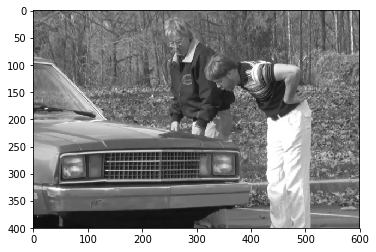

In [13]:
## Now time to merge results back into image
## This is a crappy way of doing it.. we will eventually find a better way

def merge(result_list):
    merged_rows = []
    for row in result_list:
        merged_row = row[0]
        for col in row[1:]:
            merged_row = np.concatenate((merged_row, col), axis = 1)
        merged_rows.append(merged_row)
    
    img = merged_rows[0]
    for row in merged_rows[1:]:
        img = np.concatenate((img, row), axis = 0)
    return img
        
new_image = merge(result_list)
imgplot = plt.imshow(new_image)

In [7]:
## Cool now let's do it with multiprocessors
import multiprocessing as mp


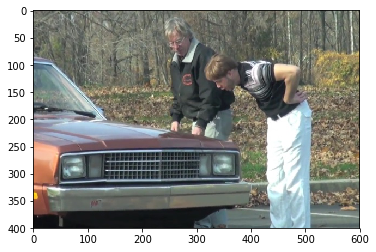

In [14]:
## We start with the original image
plt.imshow(img)

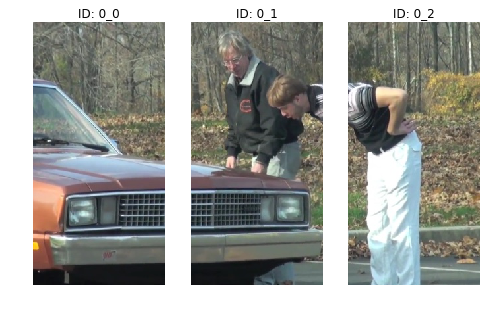

In [15]:
## We repeate the same process but this time we split to match number of processes which is 3
img_list_2 = split_2d_image(img, 1, 3)
img_dict_2 = label(img_list_2)

fig=plt.figure(figsize=(8, 8))
count = 1
for key, value in img_dict_2.items():
    fig.add_subplot(len(img_list_2), len(img_list_2[0]), count).title.set_text("ID: " + key)
    plt.imshow(value,interpolation='nearest')
    plt.axis('off')
    count += 1

plt.show()

In [32]:
## need a shared list to store results
def worker2(shared_dict, sec, key, img, lock):
    result = crappy_function(sec, img)
    lock.acquire()
    try:
        row, col = (key.split("_"))
        shared_dict[key] = result
    finally:
        lock.release()
        
        
def multiproc(sec, image_map):
    manager = mp.Manager()
    lock = mp.Lock()
    shared_list = manager.dict()
    num_workers = mp.cpu_count() - 1
    jobs = []
    for key, value in image_map.items():
        p = mp.Process(target = worker2, args = (shared_list, sec, key, value, lock))
        jobs.append(p)
        p.start()
    for job in jobs:
        job.join()
    time.sleep(.1)
    return shared_list

#result_dict_2 = multiprocessing(.001, img_dict_2)


In [33]:
def nonthreaded(data, sleep):
    result = crappy_function(sleep, data)
    return result

def threaded(data, sleep):
    data_split = split_2d_image(data, 4, 6)
    data_split = label(data_split)
    result_list = [[None for i in range(columns)] for j in range(rows)]
    threads(result_list, sleep, image_map)
    result = merge(result_list)
    return result

def multiprocessing(data, sleep):
    data_split = split_2d_image(data, 1, 3)
    data_split = label(data_split)
    return multiproc(sleep, data_split)

In [34]:
data = mpimg.imread(data_dir + "look_at_it.jpg")

from timeit import default_timer as timer

start = timer()
nonthreaded(data, .000001)
end = timer()
print("Time for Nonthreaded: " + str(end - start))

start = timer()
threaded(data, .000001)
end = timer()
print("Time for Threaded: " + str(end - start))

start = timer()
multiprocessing(data, .000001)
end = timer()
print("Time for Multiprocessing: " + str(end - start))

Time for Nonthreaded: 5.08024610101711
Time for Threaded: 6.429884796962142
Time for Multiprocessing: 3.703464019112289


# Improvements / TODOs:
- There is probably a better way to merge 
- There is definitely a better parallel programming framework
- Edge Conflicts (!!!)

Look into: Memory Mapping